In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import Subset
import numpy as np

# Load the CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Define the number of clients and the Dirichlet distribution concentration parameter
num_clients = 10
alpha = 0.5

def sample_images(class_to_indices, proportions, n):
    indices = []
    for c, prop in enumerate(proportions):
        num_samples = int(n * prop)
        samples = np.random.choice(class_to_indices[c], size=num_samples, replace=False)
        indices.extend(samples)
    return indices

"""Use Dirichlet distribution for non-iid loading"""
class_to_indices = {i: [] for i in range(num_clients)}
for idx, (_, label) in enumerate(trainset):
    class_to_indices[label].append(idx)

# Distribute the dataset in a non-iid way onto clients
client_datasets = []
n_per_client = len(trainset) // num_clients

for _ in range(num_clients):
    # Sample a proportion vector from the Dirichlet distribution
    proportions = np.random.dirichlet([alpha] * num_clients)
    
    # Sample images from each class based on the proportion vector
    client_indices = sample_images(class_to_indices, proportions, n_per_client)
    
    # Create a subset of the dataset for the client
    client_dataset = Subset(trainset, client_indices)
    client_datasets.append(client_dataset)

# Verify the distribution of samples for each client
for i, client_dataset in enumerate(client_datasets):
    print(f"Client {i}: {len(client_dataset)} samples")


Files already downloaded and verified
Client 0: 4995 samples
Client 1: 4998 samples
Client 2: 4994 samples
Client 3: 4994 samples
Client 4: 4993 samples
Client 5: 4997 samples
Client 6: 4995 samples
Client 7: 4994 samples
Client 8: 4996 samples
Client 9: 4995 samples


In [7]:
def count_datapoints_per_class(client_datasets):
    counts = []
    
    for client_dataset in client_datasets:
        client_class_counts = {i: 0 for i in range(10)}
        
        for idx in client_dataset.indices:
            _, label = trainset[idx]
            client_class_counts[label] += 1
        
        counts.append(client_class_counts)
    
    return counts

# Count the datapoints for each class in each client's dataset
datapoints_counts = count_datapoints_per_class(client_datasets)

# Print the counts for each client
for i, counts in enumerate(datapoints_counts):
    print(f"Client {i}: {counts}")


Client 0: {0: 18, 1: 1003, 2: 65, 3: 57, 4: 839, 5: 12, 6: 2729, 7: 25, 8: 143, 9: 104}
Client 1: {0: 596, 1: 938, 2: 1679, 3: 430, 4: 310, 5: 59, 6: 253, 7: 232, 8: 110, 9: 391}
Client 2: {0: 2008, 1: 630, 2: 59, 3: 13, 4: 130, 5: 530, 6: 1, 7: 426, 8: 1178, 9: 19}
Client 3: {0: 1453, 1: 25, 2: 1646, 3: 496, 4: 132, 5: 480, 6: 149, 7: 282, 8: 12, 9: 319}
Client 4: {0: 462, 1: 2, 2: 47, 3: 538, 4: 23, 5: 330, 6: 948, 7: 662, 8: 52, 9: 1929}
Client 5: {0: 238, 1: 84, 2: 741, 3: 2412, 4: 3, 5: 16, 6: 238, 7: 459, 8: 504, 9: 302}
Client 6: {0: 764, 1: 459, 2: 197, 3: 1060, 4: 9, 5: 377, 6: 116, 7: 1108, 8: 561, 9: 344}
Client 7: {0: 1792, 1: 1361, 2: 316, 3: 236, 4: 252, 5: 115, 6: 3, 7: 191, 8: 231, 9: 497}
Client 8: {0: 97, 1: 70, 2: 51, 3: 132, 4: 583, 5: 2439, 6: 168, 7: 98, 8: 198, 9: 1160}
Client 9: {0: 5, 1: 398, 2: 279, 3: 81, 4: 9, 5: 2488, 6: 853, 7: 245, 8: 567, 9: 70}


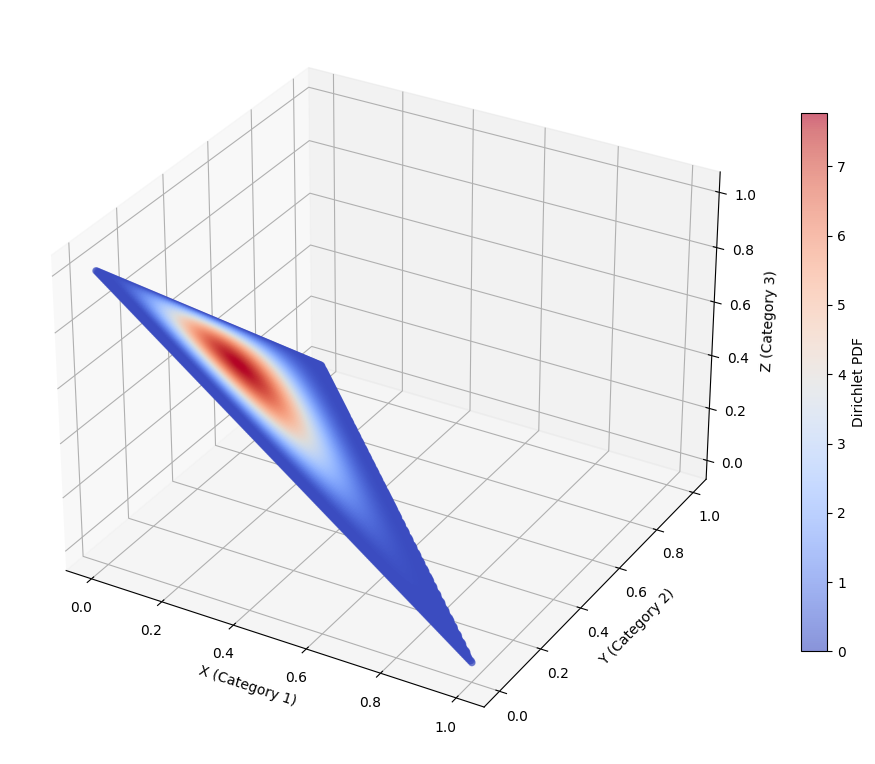

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import gamma
from matplotlib import cm

def dirichlet_pdf(x, alpha):
    num = gamma(np.sum(alpha)) * np.prod(np.power(x, alpha - 1))
    den = np.prod(gamma(alpha))
    return num / den

# Generate a 3D grid of probability vectors
resolution = 200
X = np.linspace(0, 1, resolution)
Y = np.linspace(0, 1, resolution)
X, Y = np.meshgrid(X, Y)
Z = 1 - X - Y

# Remove invalid probability vectors (i.e., where some elements are negative)
valid = Z >= 0
X, Y, Z = X[valid], Y[valid], Z[valid]

# Set the alpha values for the Dirichlet distribution
alpha = np.array([2, 3, 4])

# Calculate the Dirichlet PDF at each point on the grid
pdf = np.array([dirichlet_pdf(np.array([x, y, z]), alpha) for x, y, z in zip(X, Y, Z)])

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the probability vectors and the Dirichlet PDF
sc = ax.scatter(X, Y, Z, c=pdf, cmap=cm.coolwarm, marker='o', alpha=0.6)

# Add axis labels
ax.set_xlabel('X (Category 1)')
ax.set_ylabel('Y (Category 2)')
ax.set_zlabel('Z (Category 3)')

# Add a colorbar to show the PDF values
cb = fig.colorbar(sc, ax=ax, shrink=0.7)
cb.set_label('Dirichlet PDF')

# Display the plot
plt.show()
